# Stage 1: Preprocess VNG's data
In this stage, we will read raw data from a given dataset. The dataset consists of variable-resolution images, while our system requires a constant input dimensionality. Therefore, we need to down-sampled the images to a fixed resolution (270 x 270)

## Examples of processing
 + In the bellow code, we will crop the central region of raw image.

(480, 480, 3)
float32
('The shape of result: ', (420, 420, 3))
(420, 420, 3)


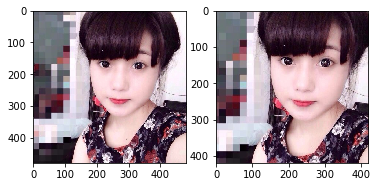

In [7]:
%matplotlib inline
import glob
import os
import numpy as np
from scipy.misc import imread, imresize
import matplotlib.pyplot as plt
import tensorflow as tf

raw_image = imread('model/datasets/nudity_dataset/3.jpg')

# Define a tensor placeholder to store an image
image = tf.placeholder("uint8", [None, None, 3])
image1 = tf.image.convert_image_dtype(image, dtype=tf.float32)
image2 = tf.image.central_crop(image1, central_fraction=0.875) # Crop the central region of raw image

model = tf.initialize_all_variables() # Quan trong

print raw_image.shape
with tf.Session() as session:
    session.run(model)
    result = session.run(image2, feed_dict={image: raw_image})
    print result.dtype
    print("The shape of result: ",result.shape)

print result.shape
## Draw image
fig = plt.figure()
a = fig.add_subplot(1,2,1)
plt.imshow(raw_image)
a = fig.add_subplot(1,2,2)
plt.imshow(result)
plt.show()


+ In the code bellow, resize image into the special resolution

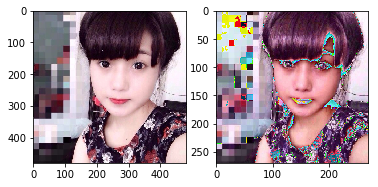

In [8]:
import numpy as np
from scipy.misc import imread, imresize
import matplotlib.pyplot as plt
import tensorflow as tf

raw_image = imread('model/datasets/nudity_dataset/3.jpg')

image = tf.placeholder("uint8", [None, None, 3])
image1 = tf.image.convert_image_dtype(image, dtype = tf.float32)
image1_t = tf.expand_dims(image1, 0)
image2 = tf.image.resize_bilinear(image1_t, [270, 270], align_corners=False)
image2 = tf.squeeze(image2, [0])

image3 = tf.sub(image2, 0.5)
image3 = tf.mul(image2, 2.0)

model = tf.initialize_all_variables()

with tf.Session() as session:
    session.run(model)
    result = session.run(image3, feed_dict={image:raw_image})

## Draw image
fig = plt.figure()
a = fig.add_subplot(1,2,1)
plt.imshow(raw_image)
a = fig.add_subplot(1,2,2)
plt.imshow(result)
plt.show()


1.1 Create a standard training dataset

In [13]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import tensorflow  as tf
import numpy as np
import matplotlib.pyplot as plt
import cPickle as pickle
from model.datasets.data import generate_standard_dataset

# Load Normal and Nude images into the train dataset

image_normal_ls, file_name_normal = generate_standard_dataset('/home/cpu11757/workspace/Nudity_Detection/src/model/datasets/train/normal')

nudity_ls, file_name_nudity = generate_standard_dataset('/home/cpu11757/workspace/Nudity_Detection/src/model/datasets/train/nude')

init_op = tf.initialize_all_variables()

labels = np.zeros(3000, dtype = np.uint)


database = []
with tf.Session() as session:
    session.run(init_op)
    # Start populating the filename queue
    coord = tf.train.Coordinator()
    tf.train.start_queue_runners(coord=coord)    
    for i in range(3000):
        print i
        if i % 2 == 0:
            image = image_normal_ls.eval()
        else:
            image = nudity_ls.eval()
            labels[i] = 1
        database.append(image)
    coord.request_stop()

database = np.array(database)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
25

In [12]:
print file_name_normal[1123]

/home/cpu11757/workspace/Nudity_Detection/src/model/datasets/train/normal/d_240.jpg


+ Generate tfrecords

In [14]:
import os
import tensorflow as tf

def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def convert_to(data_dir, dataset, labels, name):
    """Converts a dataset to tfrecords."""
    images = dataset
    labels = labels
    num_examples = dataset.shape[0]
    
    rows, cols, depth = dataset[0].shape
    
    filename = os.path.join(data_dir, name + '.tfrecords')
    
    writer = tf.python_io.TFRecordWriter(filename)
    
    for idx in range(num_examples):
        image_raw = images[idx].tostring()
        example = tf.train.Example(features = tf.train.Features(feature={
                    'height': _int64_feature(rows),
                    'width': _int64_feature(cols),
                    'depth': _int64_feature(depth),
                    'label': _int64_feature(int(labels[idx])),
                    'image_raw': _bytes_feature(image_raw)
                }))
        writer.write(example.SerializeToString())
    writer.close()

convert_to('/home/cpu11757/workspace/Nudity_Detection/src/model/datasets',
          database, labels, 'vng_dataset')


+  Read a batch images

In [32]:
import tensorflow as tf
import matplotlib.pyplot as plt

def read_and_decode(filename_queue):
    reader = tf.TFRecordReader()
    _, serialized_example = reader.read(filename_queue)
    features = tf.parse_single_example(
    serialized_example,
    features={
            'image_raw': tf.FixedLenFeature([], tf.string),
            'label': tf.FixedLenFeature([], tf.int64),
            'depth': tf.FixedLenFeature([], tf.int64),
            'width': tf.FixedLenFeature([], tf.int64),
            'height': tf.FixedLenFeature([], tf.int64)
        })
    
    image = tf.decode_raw(features['image_raw'], tf.float32)
    image = tf.reshape(image,[34,34,3])
    label = tf.cast(features['label'], tf.int32)
    height = tf.cast(features['height'], tf.int32)
    width = tf.cast(features['width'], tf.int32)
    depth = tf.cast(features['depth'], tf.int32)
    return image, label, height, width, depth

def data_input(data_dir, batch_size):
    filename_queue = tf.train.string_input_producer([data_dir], num_epochs = None)
    image, label, height, width, depth = read_and_decode(filename_queue)
    
    images_batch, labels_batch = tf.train.shuffle_batch(
        [image, label], 
        batch_size = batch_size,
        capacity = 2000,
        min_after_dequeue = 80
    )
    return images_batch, labels_batch


#filename_queue = tf.train.string_input_producer(['/home/cpu11757/workspace/Nudity_Detection/src/model/datasets/vng_dataset.tfrecords'], num_epochs = None)
#image, label, height,_,depth = read_and_decode(filename_queue)
img_batch, lb_batch = data_input('/home/cpu11757/workspace/Nudity_Detection/src/model/datasets/vng_dataset.tfrecords',500)

init_op = tf.initialize_all_variables()
fig = plt.figure()

with tf.Session() as session:
    session.run(init_op)
    coord = tf.train.Coordinator()
    tf.train.start_queue_runners(coord=coord)
    images, labels = session.run([img_batch, lb_batch])
    coord.request_stop()


1


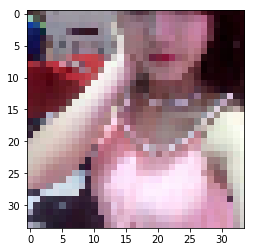

In [40]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.imshow(images[1])
print labels[0]
plt.show()

+ Example shuffle dataset

In [7]:
import tensorflow as tf

f = ["f1", "f2", "f3", "f4", "f5", "f6", "f7", "f8"]
l = ["l1", "l2", "l3", "l4", "l5", "l6", "l7", "l8"]

fv = tf.constant(f)
lv = tf.constant(l)

rsq = tf.RandomShuffleQueue(10, 0, [tf.string, tf.string], shapes=[[],[]])
do_enqueues = rsq.enqueue_many([fv, lv])

gotf, gotl = rsq.dequeue()

with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    coord = tf.train.Coordinator()
    tf.train.start_queue_runners(sess=sess,coord = coord)
    sess.run(do_enqueues)
    for i in xrange(2):
        one_f, one_l = sess.run([gotf, gotl])
        print "F: ", one_f, "L: ", one_l
    
    coord.request_stop()



F:  f3 L:  l3
F:  f5 L:  l5


+ Example cPickle

In [ ]:
import cPickle as pickle

dict1 = {'name':[],'id':[]}
dict2 = {'local':[], 'paza':[]}

#with open('test.p', 'wb') as fp:
#    pickle.dump(dict1,fp)
#    pickle.dump(dict2,fp)
    
with open('test.p', 'rb') as fp:
    d1 = pickle.load(fp)
    d2 = pickle.load(fp)

print len(d1)
print len(d2)
    

+ Example reshape

In [28]:
import tensorflow as tf
import numpy as np

a = tf.constant(np.array([[.1]]))
init = tf.initialize_all_variables()
with tf.Session() as session:
    session.run(init)
    b = session.run(tf.nn.softmax(a))
    c = session.run(tf.nn.softmax_cross_entropy_with_logits([0.6, 0.4],[0,1]))
    #print b
    #print c

label = np.array([[0], [1], [1]])
idx = np.arange(3) * 2
print ('IDX')
print idx

labels_one_hot = np.zeros((3,2))
print ('labels_one_hot')
print labels_one_hot


labels_one_hot.flat[idx + label.ravel()] = 1
print ('IDX + label.ravel()')
print idx + label.ravel()


IDX
[0 2 4]
labels_one_hot
[[ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]]
IDX + label.ravel()
[0 3 5]
